In [1]:
import tqdm
import warnings
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

In [34]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    x = cp.Variable(len(a))

    if metric == "sw":
        objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    elif metric == "pf":
        objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a**2, x) + b - L)))
    elif metric == "mm":
        objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    else:
        y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
        objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))
               
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS", abstol=1e-6)

    surplus = np.sum(-0.5*a*x.value**2 + (b - L)*x.value)
    
    return problem.value, x.value, surplus


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]
    
    np.random.seed(seed)
    a = 10*np.random.rand(n_users) + 1 
    b = (a + 1)*L + 10*np.random.rand(n_users) + 1
    
    try:
        warnings.simplefilter("error")
        assert check_feasibility(L, a, b), "infeasible"
        sw_val, sw_sol, sw_surplus = solve(L, a, b, "sw")
        pf_val, pf_sol, pf_surplus = solve(L, a, b, "pf")
        mm_val, mm_sol, mm_surplus = solve(L, a, b, "mm")
        message = "success"

    except (Warning, cp.SolverError) as e:
        sw_val, sw_sol, sw_surplus = np.nan, np.full(n_users, np.nan), np.nan
        pf_val, pf_sol, pf_surplus = np.nan, np.full(n_users, np.nan), np.nan
        mm_val, mm_sol, mm_surplus = np.nan, np.full(n_users, np.nan), np.nan
        message = str(e)
        
    return dict(
        n_users=n_users, seed=seed, message=message,
        sw_val=sw_val, sw_sol=sw_sol, sw_surplus=sw_surplus,
        pf_val=pf_val, pf_sol=pf_sol, pf_surplus=pf_surplus,
        mm_val=mm_val, mm_sol=mm_sol, mm_surplus=mm_surplus,
    )

In [35]:
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in [1] for n_users in 2**np.arange(1, 11) for seed in range(100)
]

len(params_list)

1000

In [36]:
%%time

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

In [27]:
# calculate price of fairness (pof)
df = pd.DataFrame(results).dropna()
df["pf_pof"] = (df.sw_surplus - df.pf_surplus) / df.sw_surplus
df["mm_pof"] = (df.sw_surplus - df.mm_surplus) / df.sw_surplus
df["diff_pof"] = df["mm_pof"] - df["pf_pof"]
df.loc[df.diff_pof<0, "diff_pof"] = np.nan


# aggregate
df_mean = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_pof", "mm_pof", "diff_pof"]].quantile(0.95).reset_index()

In [28]:
df.n_users.value_counts().sort_index()

2       100
4       100
8       100
16      100
32      100
64      100
128     100
256     100
512     100
1024    100
Name: n_users, dtype: int64

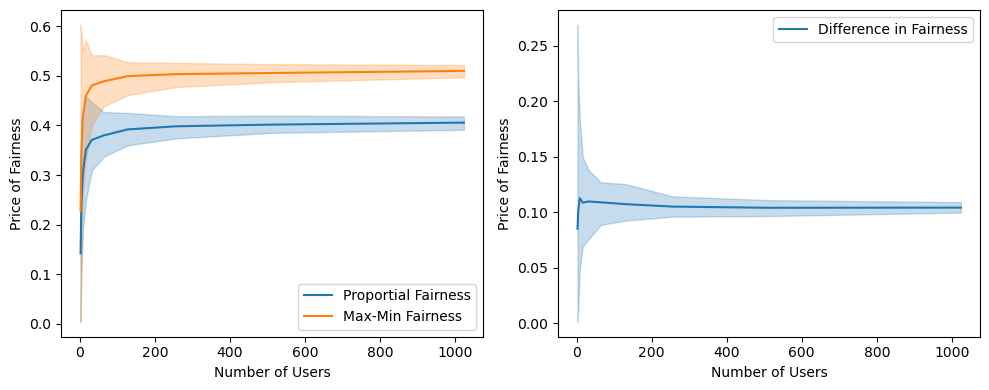

In [29]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(df_mean.n_users, df_mean.pf_pof, label="Proportial Fairness")
plt.plot(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend(loc=4)

plt.subplot(1, 2, 2)
plt.plot(df_mean.n_users, df_mean.diff_pof, label="Difference in Fairness")
plt.fill_between(df_mean.n_users, df_05.diff_pof, df_95.diff_pof, color="C0", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.tight_layout()
plt.show()

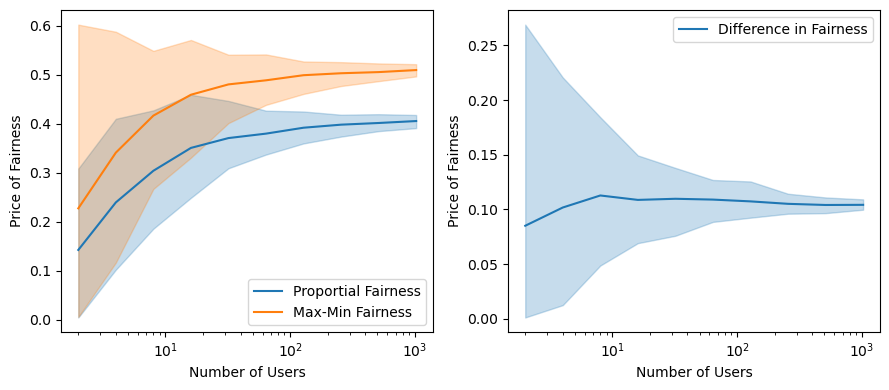

In [30]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.semilogx(df_mean.n_users, df_mean.pf_pof, label="Proportial Fairness")
plt.semilogx(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend(loc=4)

plt.subplot(1, 2, 2)
plt.semilogx(df_mean.n_users, df_mean.diff_pof, label="Difference in Fairness")
plt.fill_between(df_mean.n_users, df_05.diff_pof, df_95.diff_pof, color="C0", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend()

plt.tight_layout()
plt.show()

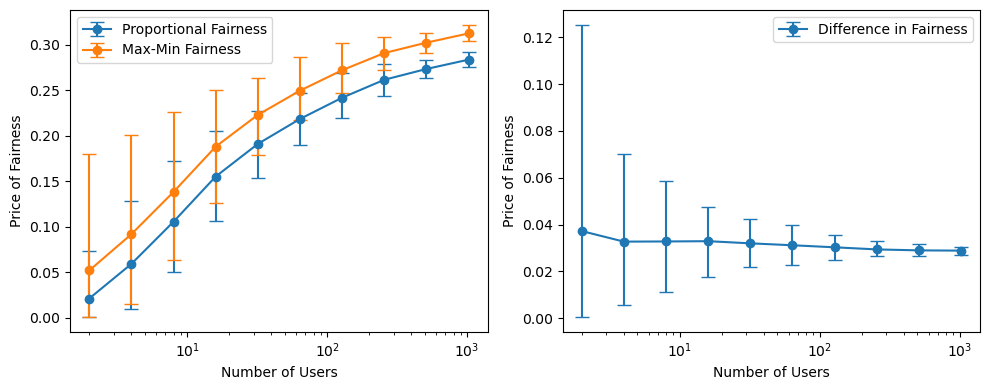

In [17]:

plt.figure(figsize=(10, 4))

# Plot 1: Proportional Fairness vs. Max-Min Fairness
plt.subplot(1, 2, 1)
plt.errorbar(df_mean.n_users, df_mean.pf_pof, 
             yerr=[df_mean.pf_pof - df_05.pf_pof, df_95.pf_pof - df_mean.pf_pof], 
             fmt='-o', label="Proportional Fairness", capsize=5)
plt.errorbar(df_mean.n_users, df_mean.mm_pof, 
             yerr=[df_mean.mm_pof - df_05.mm_pof, df_95.mm_pof - df_mean.mm_pof], 
             fmt='-o', label="Max-Min Fairness", capsize=5)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.xscale("log")
plt.legend()

# Plot 2: Difference in Fairness
plt.subplot(1, 2, 2)
plt.errorbar(df_mean.n_users, df_mean.diff_pof, 
             yerr=[df_mean.diff_pof - df_05.diff_pof, df_95.diff_pof - df_mean.diff_pof], 
             fmt='-o', label="Difference in Fairness", capsize=5)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.xscale("log")
plt.legend()

plt.tight_layout()
plt.show()
